<a target="_blank" href="https://colab.research.google.com/drive/1pbDpLKW9pbSIPrI5DbQQE2q_7eaDUAH9?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 🕷️ Chat with your webpage with `scrapegraph`, `burr` and `lancedb`

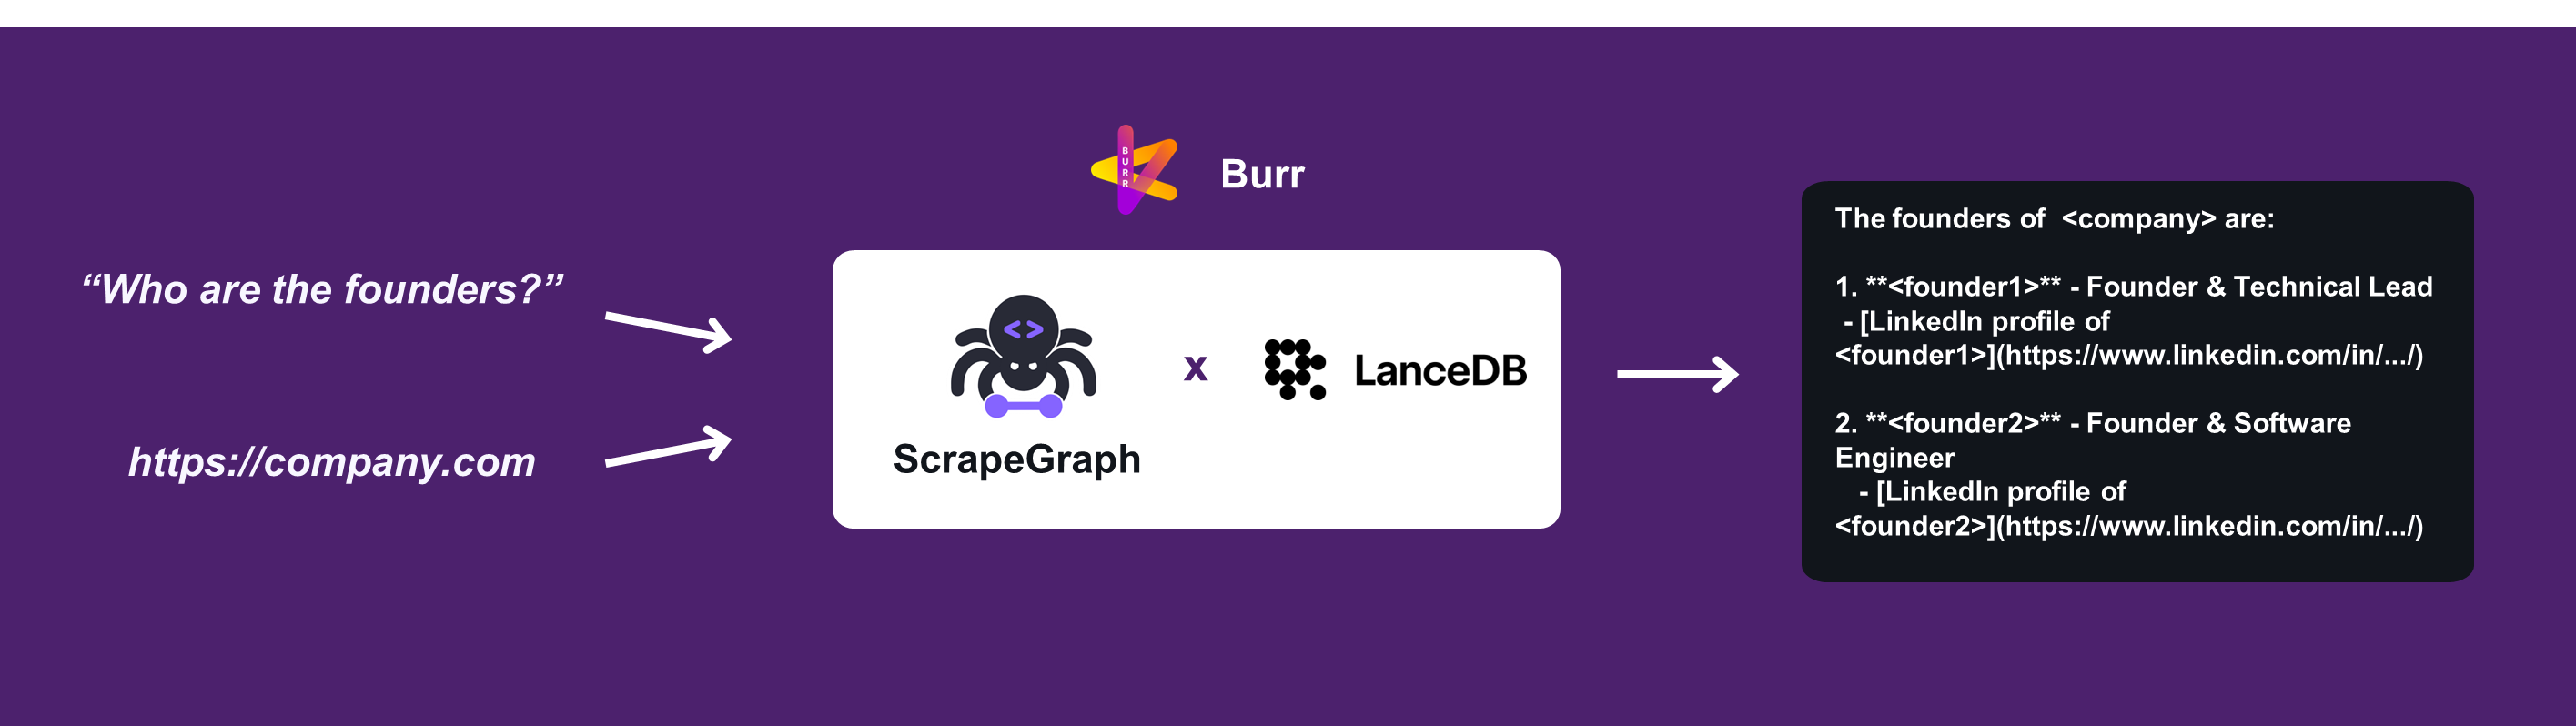

### 🔧 Install `dependencies`

In [1]:
%%capture
!pip install scrapegraph-py burr[start,opentelemetry] lancedb openai opentelemetry-instrumentation-openai opentelemetry-instrumentation-lancedb

### 🔑 Import `ScrapeGraph` and `OpenAI` API keys

You can find the Scrapegraph API key [here](https://dashboard.scrapegraphai.com/)

In [2]:
import getpass
import os

if not os.environ.get("SGAI_API_KEY"):
    os.environ["SGAI_API_KEY"] = getpass.getpass("Scrapegraph API key:\n")

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API key:\n")

Scrapegraph API key:
··········
OpenAI API key:
··········


### 🚀 Define the extraction and query flow using `burr` and run it

`burr` is an open-source `orchestrator framework` that makes it easy to develop applications that make decisions (chatbots, agents, simulations, etc...). It also features a cool self-hosted UI to trace what's happening in the application.

> Check the [Github Repo](https://github.com/DAGWorks-Inc/burr)

Our goal is to define a flow (DAG) that:

1.   Fetches markdown from webpages ([scrapegraph](https://scrapegraphai.com/))
2.   Chunks the content and stores it in a vector store ([lancedb](https://lancedb.com/))
3.   Allows to query the db and generate an answer using a LLM

We can see all of this as *Nodes* connected together in a *Graph*, where the *Nodes* are the `actions` we want to perform.

In burr we define actions by simply adding the `action decorator` to each function and specifying what that function needs to `read` and `write` from the graph's state.


All imports

In [66]:
from burr.core import action, State, ApplicationBuilder

from scrapegraph_py import Client
from scrapegraph_py.logger import sgai_logger

import re
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry

import openai
import tiktoken
from typing import List, Optional

from opentelemetry.instrumentation.lancedb import LanceInstrumentor
from opentelemetry.instrumentation.openai import OpenAIInstrumentor

#### 🔍 Define `fetch_webpage` action to fetch and convert a webpage into `markdown`

Here we use `markdownify` to fetch a webpage and convert it into markdown format, which is suitable to LLM ingestion.

You can find more info in the [official scrapegraph documentation](https://docs.scrapegraphai.com/services/markdownify)



In [67]:
sgai_logger.set_logging(level="INFO") #Optional

# Define scrapegraph sync client (API KEY is a env variable)
sgai_client = Client()


💬 2024-12-29 13:56:08,576 🔑 Initializing Client
INFO:scrapegraph:🔑 Initializing Client
💬 2024-12-29 13:56:08,582 ✅ Client initialized successfully
INFO:scrapegraph:✅ Client initialized successfully


In [68]:
@action(reads=[], writes=["markdown_content"])
def fetch_webpage(state: State, webpage_url: str) -> State:
    """Fetch a webpage and convert it to Markdown."""
    try:
        response = sgai_client.markdownify(website_url=webpage_url)
        markdown_content = response["result"]
        print(f"Request ID: {response['request_id']}")
        print(f"Markdown Content: {markdown_content[:200]}... (truncated)")
        return state.update(markdown_content=markdown_content)
    except Exception as e:
        sgai_logger.error(f"Failed to fetch webpage: {e}")
        raise

#### 📁 Define `embed_and_store` action to chunk the markdown and store it in a local vector store

Define the data structure to hold the chunks in the `lancedb` vector store

In [69]:
embedding_model = get_registry().get("openai").create()

class TextDocument(LanceModel):
    """Simple data structure to hold a piece of text associated with a url."""
    url: str
    position: int
    text: str = embedding_model.SourceField()
    vector: Vector(dim=embedding_model.ndims()) = embedding_model.VectorField()

Utils to create chunks based on the `number of tokens`

In [52]:
# Constants
CHUNK_SIZE = 2000  # Target size of each chunk in tokens
MIN_CHUNK_LENGTH_TO_EMBED = 5  # Discard chunks shorter than this

# Initialize the tokenizer
tokenizer = tiktoken.get_encoding("cl100k_base")

def get_text_chunks(text: str, chunk_token_size: Optional[int] = CHUNK_SIZE) -> List[str]:
    """
    Split text into chunks of approximately `chunk_token_size` tokens.

    Args:
        text: The input text to chunk.
        chunk_token_size: Target size of each chunk in tokens.

    Returns:
        A list of text chunks.
    """
    if not text.strip():
        return []

    tokens = tokenizer.encode(text)
    chunks = []
    chunk_size = chunk_token_size or CHUNK_SIZE

    while tokens:
        # Extract chunk tokens and decode to text
        chunk_tokens = tokens[:chunk_size]
        chunk_text = tokenizer.decode(chunk_tokens).strip()

        # Skip chunks that are too short
        if len(chunk_text) > MIN_CHUNK_LENGTH_TO_EMBED:
            chunks.append(chunk_text)

        # Remove processed tokens
        tokens = tokens[len(chunk_tokens):]

    return chunks

Let's define the action. It creates a webpages `local vector store` if not present and add the chunks to the `chunks table`

In [53]:
@action(reads=["markdown_content"], writes=[])
def embed_and_store(state: State, webpage_url: str) -> State:
    """Embed and store the Markdown content."""
    markdown_content = state["markdown_content"]

    chunks = get_text_chunks(markdown_content)

    # Embed and store the chunks using LanceDB
    con = lancedb.connect("./webpages")
    table = con.create_table("chunks", exist_ok=True, schema=TextDocument)
    table.add([
        {"text": c, "url": webpage_url, "position": i}
        for i, c in enumerate(chunks)
    ])

    return state

#### 💬 Define `ask_question` action to retrieve the most relevant chunks from the vector store and query them with a llm

Fetches the first 3 relevant chunks based on the user query and generate and answer

In [54]:
@action(reads=[], writes=["llm_answer"])
def ask_question(state: State, user_query: str) -> State:
    """Reply to the user's query using the webpage's content."""
    # Retrieve the most relevant chunks
    chunks_table = lancedb.connect("./webpages").open_table("chunks")
    search_results = (
        chunks_table
        .search(user_query)
        .select(["text", "url", "position"])
        .limit(3)
        .to_list()
    )
    relevant_content = "\n".join([r["text"] for r in search_results])

    # Prompt the LLM with the relevant content
    system_prompt = (
        "Answer the user's questions based on the provided webpage content. "
        f"WEBPAGE CONTENT:\n{relevant_content}"
    )

    client = openai.OpenAI()
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_query}
        ],
    )
    llm_answer = response.choices[0].message.content
    return state.update(llm_answer=llm_answer)

#### 🤖 Define the burr `application graph` and run it

In [ ]:
# Instrumenting OpenTelemetry for LanceDB and OpenAI
OpenAIInstrumentor().instrument()
LanceInstrumentor().instrument()

In [63]:
# Define the application graph
app = (
    ApplicationBuilder()
    .with_actions(fetch_webpage=fetch_webpage, embed_and_store=embed_and_store, ask_question=ask_question)
    .with_transitions(("fetch_webpage", "embed_and_store"), ("embed_and_store", "ask_question"))
    .with_entrypoint("fetch_webpage")
    .with_tracker(project="chat-webpage-simple-rag", use_otel_tracing=True)
    .build()
)

In [64]:
# Run the application graph
action_name, results, state = app.run(
    halt_after=["ask_question"],
    inputs={
        "webpage_url": "https://scrapegraphai.com/",
        "user_query": "Who are the founders?"
    }
)

💬 2024-12-29 13:51:54,568 🔍 Starting markdownify request for https://scrapegraphai.com/
INFO:scrapegraph:🔍 Starting markdownify request for https://scrapegraphai.com/
💬 2024-12-29 13:51:54,577 🚀 Making POST request to https://api.scrapegraphai.com/v1/markdownify
INFO:scrapegraph:🚀 Making POST request to https://api.scrapegraphai.com/v1/markdownify
💬 2024-12-29 13:51:57,646 ✅ Request completed successfully: POST https://api.scrapegraphai.com/v1/markdownify
INFO:scrapegraph:✅ Request completed successfully: POST https://api.scrapegraphai.com/v1/markdownify
💬 2024-12-29 13:51:57,649 ✨ Markdownify request completed successfully
INFO:scrapegraph:✨ Markdownify request completed successfully


Request ID: d646737f-2dbd-4c6d-aecb-fc5f2c3e132d
Markdown Content: [Star us on GitHub0](https://github.com/ScrapeGraphAI/Scrapegraph-ai)

## Transform Websites into  
Structured Data

### Just One Prompt Away

Transform any website into clean, organized data for AI a... (truncated)


In [65]:
print(state["llm_answer"])

The founders of ScrapeGraphAI are:

1. **** - Founder & Technical Lead
   - [LinkedIn profile of ](https://www.linkedin.com/in/perinim/)

2. **Marco Vinciguerra** - Founder & Software Engineer
   - [LinkedIn profile of Marco Vinciguerra](https://www.linkedin.com/in/marco-vinciguerra-7ba365242/)

3. **Lorenzo Padoan** - Founder & Product Engineer
   - [LinkedIn profile of Lorenzo Padoan](https://www.linkedin.com/in/lorenzo-padoan-4521a2154)


### 🖼️ Visualize the traces with `Burr UI`

In [70]:
# execute to load the Burr extension
%load_ext burr.integrations.notebook

In [74]:
%burr_ui

# If you want to open the ui in another window
# from google.colab import output
# output.serve_kernel_port_as_window(7241)

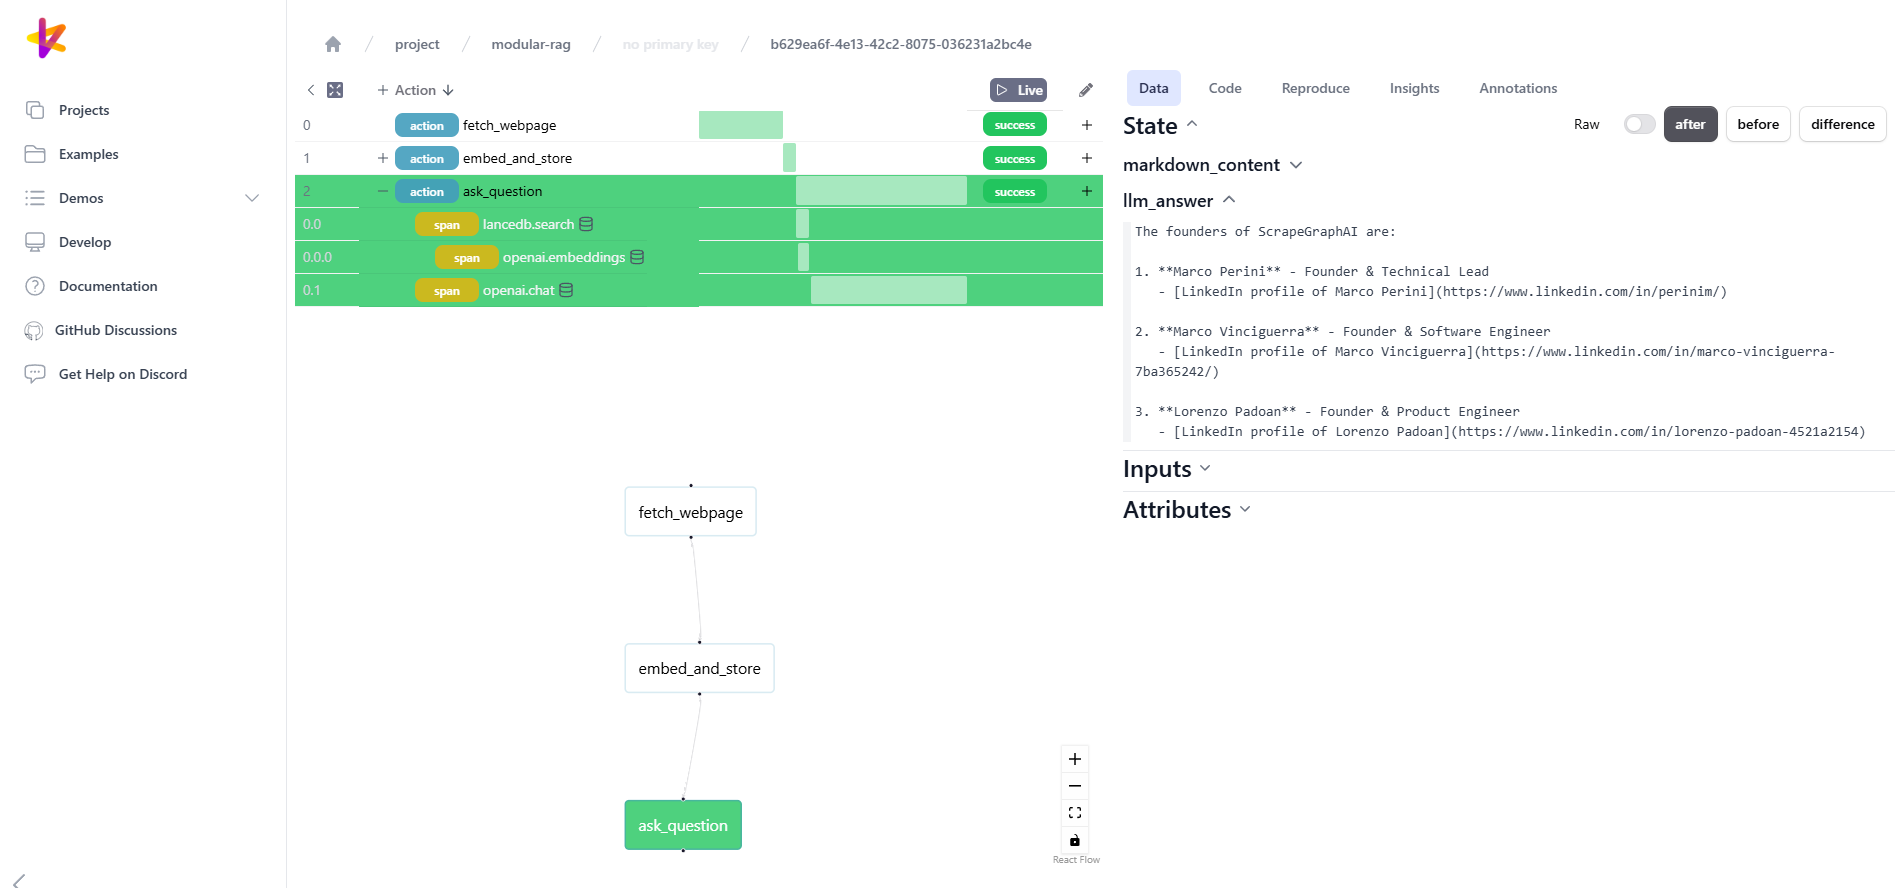

## 🔗 Resources


<p align="left">
  <img src="https://raw.githubusercontent.com/VinciGit00/Scrapegraph-ai/main/docs/assets/api-banner.png"
       alt="ScrapeGraph API Banner" width="600">
</p>


- 🚀 **Get your API Key:** [ScrapeGraphAI Dashboard](https://dashboard.scrapegraphai.com)  
- 🐙 **GitHub:** [ScrapeGraphAI GitHub](https://github.com/scrapegraphai)  
- 💼 **LinkedIn:** [ScrapeGraphAI LinkedIn](https://www.linkedin.com/company/scrapegraphai/)  
- 🐦 **Twitter:** [ScrapeGraphAI Twitter](https://twitter.com/scrapegraphai)  
- 💬 **Discord:** [Join our Discord Community](https://discord.gg/uJN7TYcpNa)  
- ⏩ **Burr:** [Github](https://github.com/DAGWorks-Inc/burr)
- 🛢️ **LanceDB:** [Github](https://github.com/lancedb/lancedb)

Made with ❤️ by the [ScrapeGraphAI](https://scrapegraphai.com) Team  
